In [1]:
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import f_regression
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error

## 1. Prepare the data, rename variables as you see fit and justify. Propose the types of data for each variable (python data types).

### Proposed Data Types:

Child's IQ should be numeric and float,

Mother's IQ should be numeric and float,

Mother's Age should be numeric and float,

Mother's Education Index should be numeric and integer,

Mother's Working Index should be numeric and integer.

I propose iq and age to be double/float because they should be continuous variables. Although due to measurement unit, child's iq and mother's age can be expressed as integers, it is better to leave them as double.

I propose education index and working index as integer because it fits better in the linear regression, and there will be an additional one-hot-encoding for working index.

In [2]:
raw_data = pd.read_csv("data.txt", sep="|")
raw_data.value_counts('variable')

variable
a        434
h        434
i        434
score    434
w        434
��င��      1
dtype: int64

*Insight*: One of the rows is not unicoded, and it seems it should be disposed because all five variables have the same number of occurances.

In [3]:
# Locate the error code
for i, val in enumerate(raw_data['index']):
    try:
        int(val)
    except:
        print(i, val)

894 0xC0


In [4]:
raw_data.iloc[894]

index        0xC0
variable    ��င��
value       ��မ�?
Name: 894, dtype: object

In [5]:
raw_data.iloc[893]


index                      893
variable                     i
value       '121.748013460479'
Name: 893, dtype: object

In [6]:
raw_data.iloc[895]

index                      894
variable                     i
value       '98.7480786989934'
Name: 895, dtype: object

*Insight*: Indeed, there is no gap in between two rows and the 0xC0 hex number is 192 also seems meaningless.

## 2. Transform the data so it's easy to analyze - describe what you did and why

### What did I do?

The raw data is a txt file and each line represents a variable value for a unit. I first used a list dictionary of variable names as keys to hold the values, and create a pandas dataframe from this dictionary object.

Then, I will run one-hot encoding for mother's working index and removing one column to avoid multicolliearity. I won't drop the original mother_work_idx for now for EDA in the next section.

In [7]:
var_list = ['score', 'h', 'i', 'w', 'a']
data_dict = {}
for var in var_list:
    data_dict[var] = []

In [8]:
for variable, value in zip(raw_data['variable'], raw_data['value']):
    if variable == raw_data.iloc[894]['variable']:
        continue
    else:
        data_dict[variable].append(value)

In [9]:
data = pd.DataFrame(data_dict)
data.columns = ['child_iq', 'mother_edu_idx', 'mother_iq', 'mother_work_idx', 'mother_age']

In [10]:
data['child_iq'] = data['child_iq'].astype("double")
data['mother_iq'] = data['mother_iq'].apply(lambda x: x[1:-1])
data['mother_iq'] = data['mother_iq'].astype("double")
data['mother_edu_idx'] = data['mother_edu_idx'].astype("int")
data['mother_work_idx'] = data['mother_work_idx'].astype("int")
data['mother_age'] = data['mother_age'].astype("double")


In [11]:
mother_work_idx_dummy = pd.get_dummies(data['mother_work_idx'])
mother_work_idx_dummy.columns = ['no_work_three_years', 'no_work_first_year', 'part_time_first_year', 'full_time_first_year']
mother_work_idx_dummy.drop('no_work_three_years', inplace=True, axis=1)
data = pd.concat((data, mother_work_idx_dummy), axis=1)

In [12]:
data.head()

,child_iq,mother_edu_idx,mother_iq,mother_work_idx,mother_age,no_work_first_year,part_time_first_year,full_time_first_year
0,65.0,1,121.117529,4,27.0,0,0,1
1,98.0,1,89.361882,4,25.0,0,0,1
2,85.0,1,115.443165,4,27.0,0,0,1
3,83.0,1,99.449639,3,25.0,0,1,0
4,115.0,1,92.745710,4,27.0,0,0,1


*Insight*: It is unclear how mother_iq can have so many decimal places, but in linear regression, the decimal places won't make a big difference so I will keep those values.

## 3. Perform the exploratory data analysis

I will visulize the data by correlation map, histplots, and boxplots.

I will then statistically test feautres' importances through ANOVA and correlation coefficient.

In [13]:
data.isna().sum()

child_iq                0
mother_edu_idx          0
mother_iq               0
mother_work_idx         0
mother_age              0
no_work_first_year      0
part_time_first_year    0
full_time_first_year    0
dtype: int64

- ### Correlation Map

<AxesSubplot:>

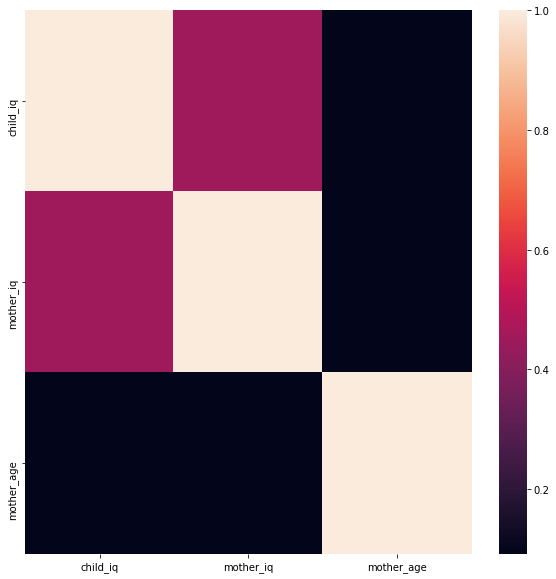

In [14]:
plt.figure(figsize=(10,10))
sbn.heatmap(data[['child_iq', 'mother_iq', 'mother_age']].corr())

*Insight*: Multicollienarity is not a big issue here, but explanatory variables do not have a high correlation with the response variable either.

In [15]:
def distribution_dist_plots(data, features, ncols):
    nrows = int(len(features) / ncols) + 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, round(nrows*16/ncols)))
    for ax,feature in zip(axes.ravel()[:len(features)],features):
        sbn.histplot(data[feature][data[feature].notnull()],ax=ax)
    for ax in axes.ravel()[len(features):]:
        ax.set_visible(False)
    fig.tight_layout()
    plt.show()


- ### Plot distributions

    - Continuous Variables Distribution

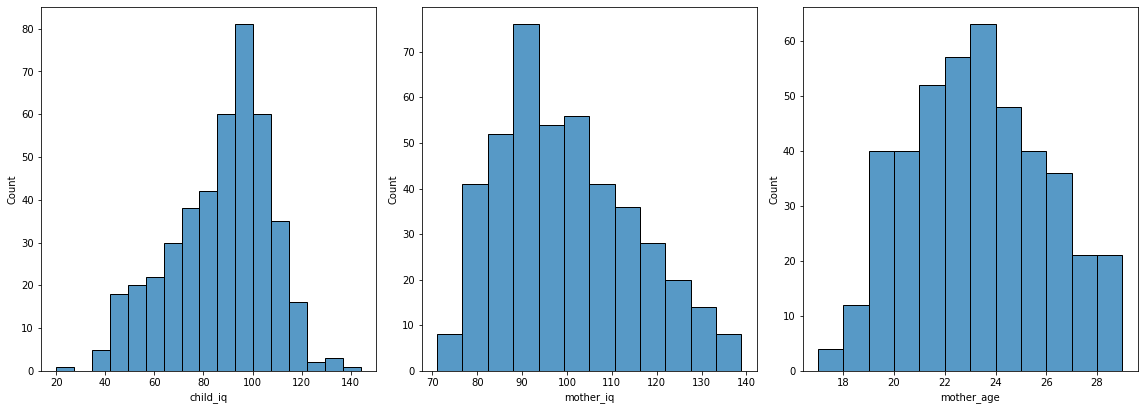

In [16]:
distribution_dist_plots(data, ['child_iq', 'mother_iq', 'mother_age'], 3)

*Insight*: Mother's age is approximately normal, Child's IQ is slightly left skewed and Mother's IQ is slightly right skewed.

    - Child's IQ v.s. Mother's IQ

Text(0, 0.5, "Child' IQ")

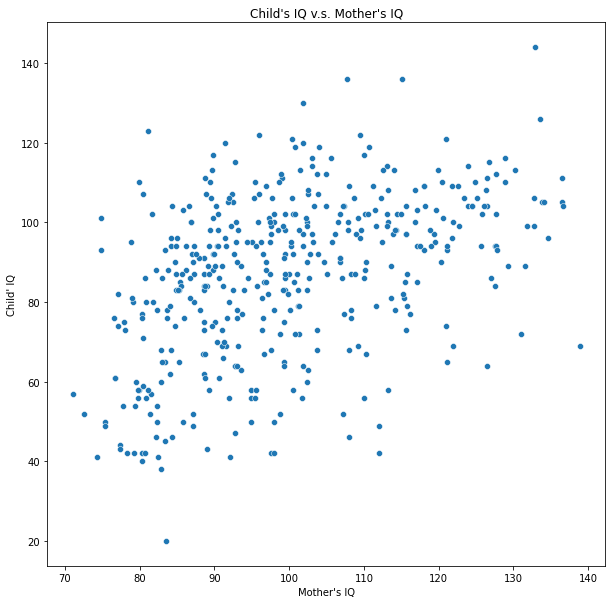

In [17]:
plt.figure(figsize=(10,10))
sbn.scatterplot(data=data, x='mother_iq', y='child_iq')
plt.title('Child\'s IQ v.s. Mother\'s IQ')
plt.xlabel('Mother\'s IQ')
plt.ylabel('Child\' IQ')

*Insight*: the relationship between Child's IQ and Mother's IQ is approximately linear.

    - Comparison of Distirbutions Among Categorical Variables

<AxesSubplot:xlabel='mother_age', ylabel='child_iq'>

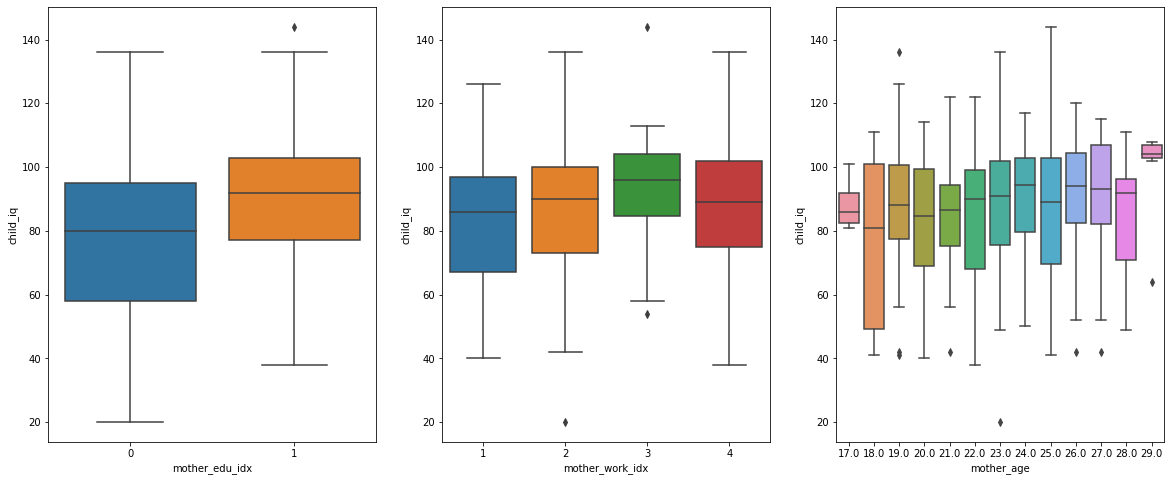

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(20,8))
sbn.boxplot(data=data, x='mother_edu_idx', y='child_iq', ax=axes[0])
sbn.boxplot(data=data, x='mother_work_idx', y='child_iq', ax=axes[1])
sbn.boxplot(data=data, x='mother_age', y='child_iq', ax=axes[2])


*Insight*: Mother's Educatoin Level seems like an important predictor.

    - Categorical Variable Distributions

<AxesSubplot:xlabel='mother_work_idx', ylabel='count'>

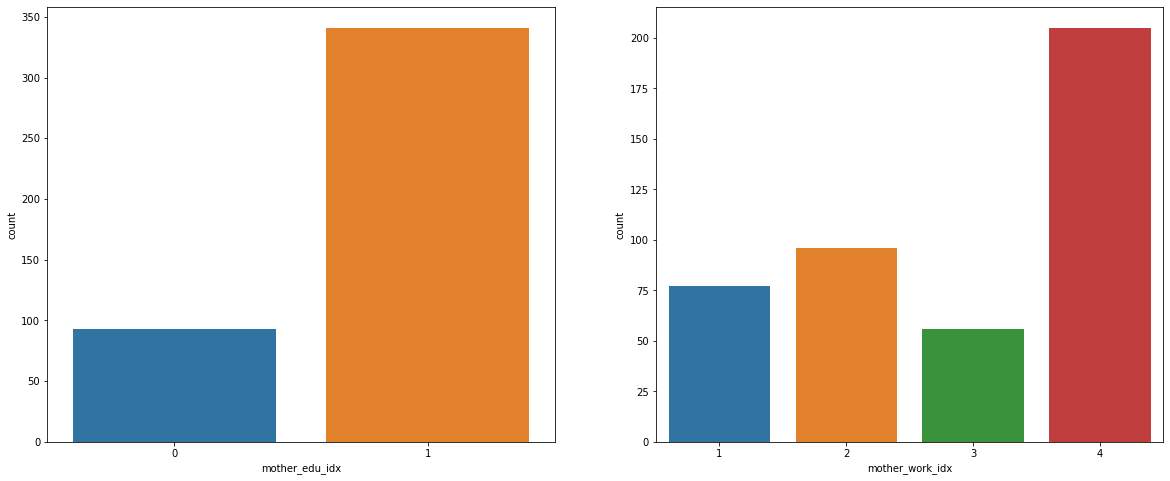

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(20,8))
sbn.countplot(data=data, x='mother_edu_idx', ax=axes[0])
sbn.countplot(data=data, x='mother_work_idx',ax=axes[1])


*Insight*: Most mothers have high school degree, and most mothers choose to work in full-time for the first year since giving birth.

    - New Feature: Interaction between mother work index and mother education level

Text(0.5, 0, '1: No High School Degree and No Work in the First Three Years; 0: Otherwise')

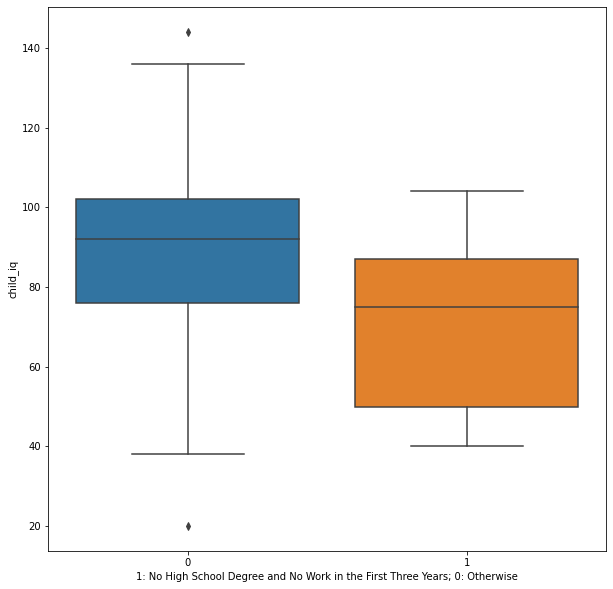

In [20]:
data['no_work_no_degree'] = (data['mother_work_idx']==1) * (1-data['mother_edu_idx'])
plt.figure(figsize=(10,10))
sbn.boxplot(x= data['no_work_no_degree'], y=data['child_iq'])
plt.xlabel("1: No High School Degree and No Work in the First Three Years; 0: Otherwise")

- ### Statistical Testings

    - ANOVA

In [21]:
anova_scores = f_regression(data[['mother_edu_idx', 'mother_work_idx', 'mother_age', 'no_work_no_degree']], data[['child_iq']])
anova_df = pd.DataFrame(anova_scores[1], columns=['ANOVA P-Value'], index=['mother_edu_idx', 'mother_work_idx', 'mother_age', 'no_work_no_degree'])
anova_df.sort_values('ANOVA P-Value', ascending=True, inplace=True)

c:\Users\86773\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
anova_df

,ANOVA P-Value
mother_edu_idx,5.956524e-07
no_work_no_degree,2.231062e-06
mother_age,5.547935e-02
mother_work_idx,6.850355e-02


    - Correlation Coefficients

In [23]:
corr = [np.corrcoef(data['mother_iq'], data['child_iq'])[0][1], \
    np.corrcoef(data['mother_age'], data['child_iq'])[0][1]]
corr = pd.DataFrame(corr, columns=['Correlation'], index=['mother_iq', 'mother_age'])
corr.sort_values('Correlation', ascending=True, inplace=True)


In [24]:
corr

,Correlation
mother_age,0.091998
mother_iq,0.448276


*Insight*: Mother's Education has a strong predictive power by ANOVA test, and mother_iq is another strong predictor by its Pearson correlation coefficient. The new feature I did is also strong so it could be used in 4.3. Mother's age or mother's work status are not very important.

## 4. Perform a linear regression where the regressand is child's IQ
    1. using a single predictor

I choose to use mother_iq as the predictor because there exists a linear relation between mother_iq and child_iq, mother_iq and child_iq has a moderately high correlation, and it intuitively makes sense.

In [25]:
X = data[['mother_iq']]
X = sm.add_constant(X, prepend=False)
mod = sm.OLS(data[['child_iq']], X)
reg = mod.fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:               child_iq   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     108.6
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           7.66e-23
Time:                        21:58:13   Log-Likelihood:                -1875.6
No. Observations:                 434   AIC:                             3755.
Df Residuals:                     432   BIC:                             3763.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mother_iq      0.6100      0.059     10.423      0.0

In [26]:
print("RMSE is", np.sqrt(np.mean(reg.resid**2)))
print("Mean absolute percentage error is", mean_absolute_percentage_error(data['child_iq'],reg.predict(X)))

RMSE is 18.223986351421466
Mean absolute percentage error is 0.19966954284067015


c:\Users\86773\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted IQ')

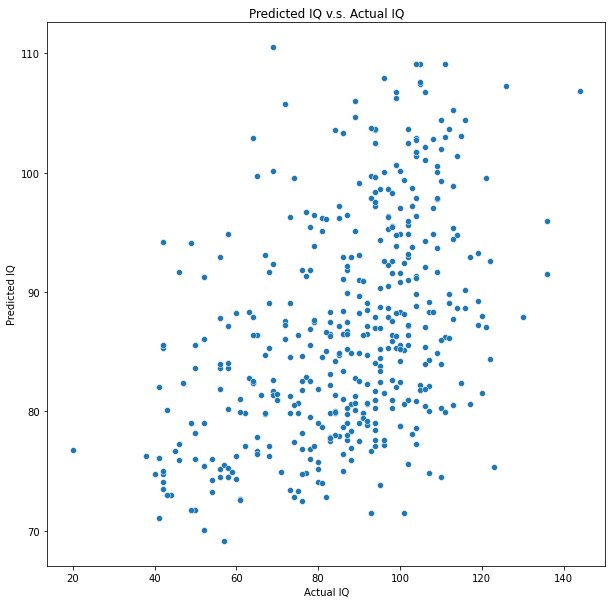

In [27]:
plt.figure(figsize=(10,10))
sbn.scatterplot(data['child_iq'], reg.predict(X))
plt.title('Predicted IQ v.s. Actual IQ')
plt.xlabel('Actual IQ')
plt.ylabel('Predicted IQ')

c:\Users\86773\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Error')

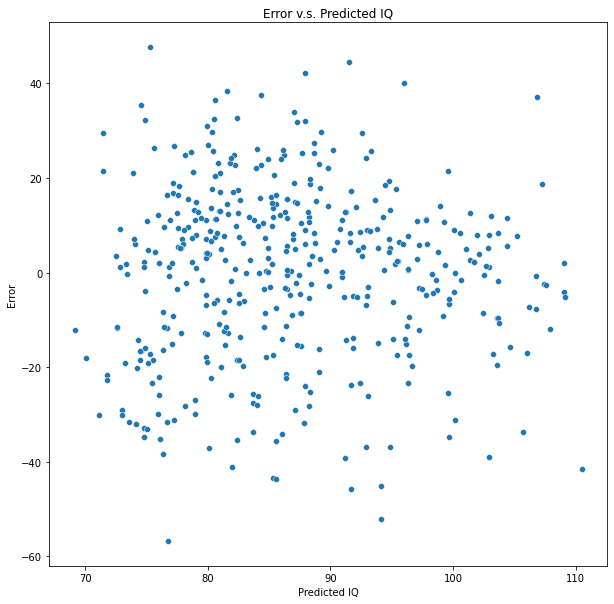

In [28]:
plt.figure(figsize=(10,10))
sbn.scatterplot(reg.predict(X), reg.resid)
plt.title('Error v.s. Predicted IQ')
plt.xlabel('Predicted IQ')
plt.ylabel('Error')

*Model Explanation*:
This is a simple linear regression model, with mother's iq as the only feature to predict child's iq. An interception term is added to center the residual.

*Model Assumption*: The assumption is that there exists a linear relationship between mother's iq and child's iq. Also, the errors should have equal variance.

*Regression Results*: 

Mother's IQ is clearly an important predictor. It achieves an RMSE of 18.22 and MAPE of 20%. So, on average, the predicted value is within 20% of it actual value.

The interpretation is that one more mother's iq corresponds to 0.61 child's iq. This is the so-called regression effect, if the explanatory variable goes up by 1 s.d., then the response variable only goes up by around 0.45 (its correlation) s.d. 

By the Error v.s. Predicted IQ plot, we can see that there isn't an obvious heterskadasity issue. 

By the Predicted IQ v.s. Actual IQ plot, we can also see this regression effect problem: the prediction is always more "conservative" than the actual IQ.

In conclusion, the assumptions of linear regression satisfied, and 1 unit increase in mother's iq corresponds to 0.61 unit increase in child's iq. Also, 1 s.d. increase in mother's iq corrspond to 0.45 s.d. increase in child's iq.

    2. using multiple predictors

In [29]:
X = data[['mother_iq', 'mother_edu_idx']]
X = sm.add_constant(X, prepend=False)
mod = sm.OLS(data[['child_iq']], X)
reg = mod.fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:               child_iq   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     58.72
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           2.79e-23
Time:                        21:58:14   Log-Likelihood:                -1872.0
No. Observations:                 434   AIC:                             3750.
Df Residuals:                     431   BIC:                             3762.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
mother_iq          0.5639      0.061      9.

In [30]:
print("RMSE is", np.sqrt(np.mean(reg.resid**2)))
print("Mean absolute percentage error is", mean_absolute_percentage_error(data['child_iq'],reg.predict(X)))

RMSE is 18.072886832854252
Mean absolute percentage error is 0.19768132716529077


*Model Explanation*: The model is a multiple linear regression model containing two features: mother's iq and mother's education background index: 1 means she has high school education and 0 otherwise. An interception term is also included to center the residual.

*Model Assumption*: The assumption is that there exists a linear relationship between mother's iq and child's iq, and mother's education background is important for explaning child's iq. The two explanatory features should be orthogonal. Also, the errors should have equal variance.

*Regression Results*: I include mother_iq and mother_edu_idx because they are the features that are verified to be important by visulization and statistical testing. I exlcude age and work status as they are not important and may add extra variance to the model to reduce the statistical power of their t-test results.

This multiple regression model has a RMSE of 18.07 and AMPE of 19.8%, similar to that performance of single linear regression. However, since this project is more about inference than predicting, the coefficients contain more information.

Both mother_iq and mother_edu_idx are important features. The interpretation is: keep mother's education level fixed, one more mother's iq is equivalent to 0.56 increase in child's iq by the model. **This is the genetic aspect of IQ**.

On the other hand, keep the mother's iq fixed, having a high school degree leads to 5.9 more iq of her child's iq. **This is the family education aspect of IQ**.

    3. using multiple predictors with an interaction term


In [31]:
X = data[['mother_iq', 'mother_edu_idx', 'no_work_no_degree']]
X = sm.add_constant(X, prepend=False)
mod = sm.OLS(data[['child_iq']], X)
reg = mod.fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:               child_iq   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     40.82
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           3.16e-23
Time:                        21:58:14   Log-Likelihood:                -1869.9
No. Observations:                 434   AIC:                             3748.
Df Residuals:                     430   BIC:                             3764.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
mother_iq             0.5556      0.06

In [32]:
print("The correlation between the interaction term and the education feature is", np.corrcoef(data['no_work_no_degree'], data['mother_edu_idx'])[0][1])

The correlation between the interaction term and the education feature is -0.5493137863828143


In [33]:
print("The new feature is well-balanced because the ratio of samples who has a one for this feature is", np.mean(data['no_work_no_degree']))

The new feature is well-balanced because the ratio of samples who has a one for this feature is 0.07603686635944701


In [277]:
print("RMSE is", np.sqrt(np.mean(reg.resid**2)))
print("Mean absolute percentage error is", mean_absolute_percentage_error(data['child_iq'],reg.predict(X)))

RMSE is 17.986471100936896
Mean absolute percentage error is 0.19663103979925045


*Model Explanation*: This is a multiple linear regression model with three features: mother's iq, mother's education index, and an interaction term as an indicator:  1 means the mother does not have a college degree and did not work the first three years since giving birth. This term includes the interaction effect between education index and work index.

*Model Assumption*: The assumption is that there exists a linear relationship between mother's iq and child's iq, and mother's education background and the interaction term are important for explaning child's iq. The three explanatory features should be orthogonal. This assumption is mildly violated. Also, the errors should have equal variance.

*Regression Results*: 

Here, in addition of mother's iq and mother's education background, I include an interaction indicator.

Of course, this new interaction term is correlated with education index, therefore we see the mother's education index is no longer significant. But both the new feature and mother's iq are important. we can also see a drop in both RMSE and MAPE and a slight increase in adjusted R-square.

The interpretation of mother's iq and mother's education background remain similar. The interesting feature is the interaction term. It means that keep mother's iq fixed, if the mother does not have high school education, then not working for the first three years will have a signifiicantly negative impact on her child's IQ. However, for mothers who have high school education, it is not reasonable to use this interpretation.